In [1]:
import torchfile
import matplotlib.pylab as plt
import numpy as np
from PIL import Image, ImageFilter
from PIL import Image
from __future__ import print_function
from keras.preprocessing.image import load_img, img_to_array
from scipy.misc import imsave
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse
from keras.applications import vgg16
from keras import backend as K
%matplotlib inline
import os
from subprocess import call

Using TensorFlow backend.


## Read in Image

In [2]:
content_path = '/home/ec2-user/Notebooks/Style_transfer/content/'
style_path = '/home/ec2-user/Notebooks/Style_transfer/style/'
def print_and_choose_content_style(content_path,style_path):
    print('content: ', os.listdir(content_path))
    print('\n')
    print('style: ', os.listdir(style_path))
    print('\n')
    is_good = False
    while not is_good:
        content_suffix = input('Which content file would you like to plot? ')
        plt.imshow(Image.open(content_path+content_suffix))
        plt.show()
        style_suffix = input('Which style file would you like to plot? ')
        plt.imshow(Image.open(style_path+style_suffix))
        plt.show()
        print('is this content good? ', content_suffix)
        print('is this style good? ', style_suffix)
        user_input = input('Answer ( True or False) : ')
        is_good = user_input
    image = Image.open(content_path+content_suffix)
    return(content_suffix,style_suffix,image)

content:  ['istock-000057793060-large.jpg', 'Pound_layer_cake.jpg', 'Wildlife-Lion-Cubs-Africa-Lions-Nature-Kenya-1284068.jpg', 'o.jpg', '54ac570043435_-_elle-06-emma-watson-red-carpet-v-elv.jpg', 'cat.jpg', 'lilcat_edit.jpg', '8220518b6edf5926e9367ad98432d711.jpg', 'donut.jpg', 'Emma-Watson-at-Colonia-film-premiere.jpg', 'fruits.jpg', 'filtered_edit.jpg', 'rehost%2F2016%2F9%2F13%2F8a6af7a7-1381-47d8-a9b8-c070e14d69e5.jpg', 'san-francisco.jpg', 'lilcatOG.jpg', 'zackdog.jpg', 'emma-watson-style-inspiration-red-pink-dress-red-carpet.jpg', 'iieXN.jpg', '160208120742-james-bond-db-10-super-169.jpg', 'fruit.jpg', '1680px-SanFrancisco_from_TwinPeaks_dusk_MC.jpg', 'fruit_things.jpg', 'watson1-466758.jpg', 'fruit_selection_155265101_web.jpg', 'lilcat.jpg', '20170215_280_hkhanjian_h_720-1.jpg']


style:  ['batman2.jpg', 'edo.jpg', 'mao.jpg', '.DS_Store', 'original.jpg', 'war1.jpg', '1262542021_9e5f143522_z.jpg', 'batman.jpg', 'batman3.jpg', 'fern.jpg', 'img_20170327_220713.jpg', 'Starry-Night.j

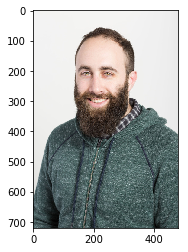

Which style file would you like to plot? fern_360.jpg


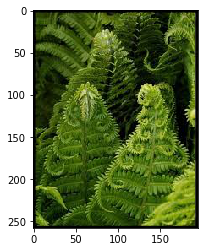

is this content good?  20170215_280_hkhanjian_h_720-1.jpg
is this style good?  fern_360.jpg
Answer ( True or False) : True


In [3]:
content_suffix, style_suffix, image = print_and_choose_content_style(content_path,style_path)

## Run Torch code to get masks/objects 

In [ ]:
Image.open('./output.jpg')

In [4]:
def run_multipath(content_suffix):
    os.chdir('/home/ec2-user/src/multipathnet/') 
    ## will print out the masked image
    command ='th run.lua -img /home/ec2-user/Notebooks/Style_transfer/content/{} >output.txt'.format(content_suffix)
    call(command,shell=True)
    Image.open('./output.jpg')
    print('multipath is done!')

In [5]:
run_multipath(content_suffix)
try:
    objects = open('./output.txt').read().split('\t\n~\t\n')[1].split('\t\n')[4::]
    objects = [objects[i].split('\t') for i in range(len(objects))]
    del objects[-1]
    objects
except:
    objects = 0

multipath is done!


In [6]:
objects

[['0.99422609806061', '1', 'person']]

# Read in the saved masks

In [7]:
def get_masks():
    masks = torchfile.load('../../src/multipathnet/christian_masks/tmp_masks.t7')
    im_shape = masks.T.shape[0:2]
    return im_shape,masks

In [8]:
im_shape, masks = get_masks()

## Visualize the masks

## Segmenting both objects in images

In [9]:
def visualize_masks(masks,image,im_shape):
#     for mask in masks:
#         plt.matshow(mask,alpha = 0.8)
#         plt.show()
    image = image.resize(im_shape)
    for i in range(len(masks)):
        plt.imshow(image,cmap = 'copper')
        plt.imshow(masks[i],alpha =0.5,cmap = 'copper')
        plt.show()
    plt.imshow(image,cmap = 'copper')
    plt.imshow(sum(masks),alpha = 0.5,cmap ='copper')
    return image

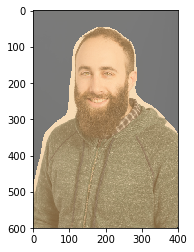

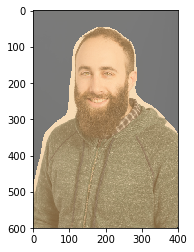

In [10]:
image = visualize_masks(masks,image,im_shape)

## Function to get masked image back

In [11]:
def get_masked_images(image,masks):
    # create mask with same dimensions as image
    all_masked_images = []
    mask_3_layer = []
    objects = 0
    for m in range(len(masks)):
        mask = np.zeros_like(image)
        # copy your image_mask to all dimensions (i.e. colors) of your image
        for i in range(3): 
            mask[:,:,i] = masks[m].copy()
        # apply the mask to your image
            masked_image = image*mask
        mask_3_layer.append(mask)
        plt.imshow(masked_image) 
        plt.show()
        all_masked_images.append(masked_image)
    plt.imshow(sum(all_masked_images))
    try:
        objects = open('./output.txt').read().split('\t\n~\t\n')[1].split('\t\n')[4::]
        objects = [objects[i].split('\t') for i in range(len(objects))]
        del objects[-1]
        num_of_objects = len(objects)
        print('It worked!')
    except:
        num_of_objects = 0
        print('no objects detected/No Masks/Error!')
    
    return np.array(all_masked_images),np.array(mask_3_layer),objects

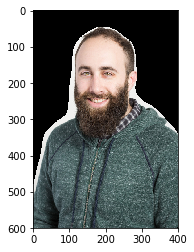

It worked!


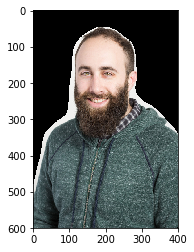

In [12]:
masked_image, mask3,objects = get_masked_images(image, masks)

In [13]:
# temp_im = Image.fromarray(masked_image[0])
# # filter = ImageFilter.GaussianBlur(radius = 0.50)
# # temp_im = temp_im.filter(filter)
# temp_im.save('/home/ec2-user/Notebooks/Style_transfer/masked_images/all_masked.jpg')

In [14]:
def save_masked_images(masked_image,masks):
    n = len(masks)
    ## ideally, I'd like to pass the name of the object that is being masked...
    for i in range(0,n):
        im = Image.fromarray(masked_image[i])
        im.save('/home/ec2-user/Notebooks/Style_transfer/masked_images/masked_image{}.jpg' .format(i))

In [15]:
save_masked_images(masked_image)

TypeError: save_masked_images() missing 1 required positional argument: 'masks'

In [16]:
def multipath_masks_full(image,content_suffix):
    run_multipath(content_suffix)
    im_shape, masks = get_masks()
    image = visualize_masks(masks,image,im_shape)
    masked_image, mask3,objects = get_masked_images(image, masks)
    save_masked_images(masked_image,masks)
    return(masks,masked_image,im_shape,mask3)

multipath is done!


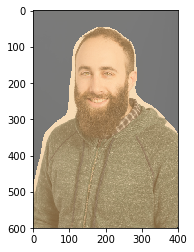

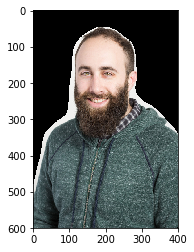

It worked!


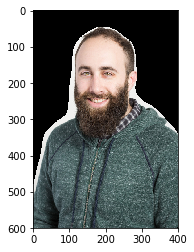

In [17]:
masks,masked_image,im_shape,mask3 = multipath_masks_full(image,content_suffix)

### View Transferred Images

In [18]:
def get_style_back(path):
    N=len(masks)
    if path == '/home/ec2-user/Notebooks/Style_transfer/output/':
        for i in range(N):
            plt.imshow(Image.open(path + 'transfered_image_at_iteration_{}.png'.format(i)).resize(im_shape))
            plt.title('file: '+ str(i))
            plt.show()
        style_back = Image.open(path +'transfered_image_at_iteration_{}.png'.format(N-1))
    else:
        style_back = Image.open(path).resize(im_shape)
    return(style_back)

In [19]:
def combine_back_to_image(style_back,alpha,m):
    style_temp= Image.fromarray(style_back*mask3[m])
    plt.figure(figsize = (10,10))
    plt.imshow(image)
    plt.imshow(np.array(image)-mask3[m]*np.array(image)+style_back*mask3[m],alpha=alpha)

In [20]:
def all_masked_into_one(masked_image):
    all_masks = sum(masked_image)
    image_masks = Image.fromarray(all_masks)
    path ='/home/ec2-user/Notebooks/Style_transfer/masked_images/all_masked.jpg'
    image_masks.save(path)
    return(image_masks,path,all_masks)

In [21]:
def do_all_style_transfer():
    from Style_transfer_image import style_transfer
    ## Change directory to the style transfer directory
    os.chdir('/home/ec2-user/Notebooks/Style_transfer') 
    style_transfer(content_path + content_suffix,style_path + style_suffix,2,1,12,1)
    style_back = get_style_back('/home/ec2-user/Notebooks/Style_transfer/output/',2)
    combine_back_to_image(style_back,1,2)

## GET USER INPUT

In [22]:
os.chdir('/home/ec2-user/Notebooks/Style_transfer') 
from Style_transfer_image import style_transfer

content:  ['istock-000057793060-large.jpg', 'Pound_layer_cake.jpg', 'Wildlife-Lion-Cubs-Africa-Lions-Nature-Kenya-1284068.jpg', 'o.jpg', '54ac570043435_-_elle-06-emma-watson-red-carpet-v-elv.jpg', 'cat.jpg', 'lilcat_edit.jpg', '8220518b6edf5926e9367ad98432d711.jpg', 'donut.jpg', 'Emma-Watson-at-Colonia-film-premiere.jpg', 'fruits.jpg', 'filtered_edit.jpg', 'rehost%2F2016%2F9%2F13%2F8a6af7a7-1381-47d8-a9b8-c070e14d69e5.jpg', 'san-francisco.jpg', 'lilcatOG.jpg', 'zackdog.jpg', 'emma-watson-style-inspiration-red-pink-dress-red-carpet.jpg', 'iieXN.jpg', '160208120742-james-bond-db-10-super-169.jpg', 'fruit.jpg', '1680px-SanFrancisco_from_TwinPeaks_dusk_MC.jpg', 'fruit_things.jpg', 'watson1-466758.jpg', 'fruit_selection_155265101_web.jpg', 'lilcat.jpg', '20170215_280_hkhanjian_h_720-1.jpg']


style:  ['batman2.jpg', 'edo.jpg', 'mao.jpg', '.DS_Store', 'original.jpg', 'war1.jpg', '1262542021_9e5f143522_z.jpg', 'batman.jpg', 'batman3.jpg', 'fern.jpg', 'img_20170327_220713.jpg', 'Starry-Night.j

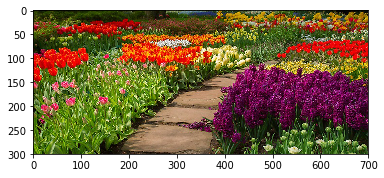

Which style file would you like to plot? Van-Gogh-Irises.jpg


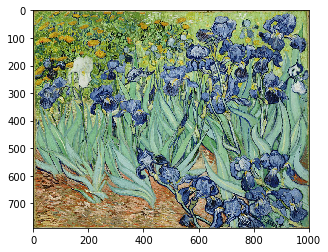

is this content good?  istock-000057793060-large.jpg
is this style good?  Van-Gogh-Irises.jpg
Answer ( True or False) : True


In [36]:
content_suffix, style_suffix, image = print_and_choose_content_style(content_path,style_path)

In [37]:
def user_chooses(image,content_suffix, style_suffix, N_iterations, content_w, style_w):
    os.chdir('/home/ec2-user/Notebooks/Style_transfer') 
    from Style_transfer_image import style_transfer
    print('Ready To Style Transfer?')
    is_good =False
    
    while not is_good:
        
        user_input = input('do you want to style_transfer the whole image?(1) or objects in image(2)?: ')
        if user_input == '1':
            # style transfer whole image
            style_transfer(content_path + content_suffix,style_path + style_suffix,N_iterations,content_w,style_w,10)
            style_back = get_style_back('/home/ec2-user/Notebooks/Style_transfer/output/transfered_image_at_iteration_{}.png'.format(N_iterations-1))
            plt.figure(figsize = (10,10))
            plt.imshow(style_back)
            
        elif user_input == '2':
            ## Style transfer segments
            user_input_2 = input(
                'Do you want to style transfer all objects detected(1), or just specific objects?(2): ')
            ##style transfer all objects in image
            
            ## run multipath!
            masks,masked_image,im_shape,mask3 = multipath_masks_full(image,content_suffix)
            if user_input_2 == '1':
                plt.figure(figsize = (10,10))
                all_masked_image, all_masked_path,all_mask = all_masked_into_one(masked_image)
                style_transfer(all_masked_path,style_path+style_suffix,N_iterations,content_w,style_w,10)
                style_back = get_style_back(
                    '/home/ec2-user/Notebooks/Style_transfer/output/transfered_image_at_iteration_{}.png'.format(N_iterations-1))
                plt.imshow(style_back)
                all_mask = sum(mask3)
                image = image.resize(im_shape)
                plt.imshow(np.array(image) - np.array(image)*all_mask + style_back*all_mask)
                
            elif user_input_2 == '2':
                ## style transfer certain images
                print("List of detected objects and their number: ")
                user_m = input('which mask?: ')
                partial_path = '/home/ec2-user/Notebooks/Style_transfer/masked_images/masked_image{}.jpg'.format(user_m)
                N_iterations = 3
                style_transfer(partial_path,style_path+style_suffix,N_iterations,content_w,style_w,10)
                style_back = get_style_back(
                    '/home/ec2-user/Notebooks/Style_transfer/output/transfered_image_at_iteration_{}.png'.format(N_iterations-1))
                plt.figure(figsize = (10,10))
                plt.imshow(style_back)
                combine_back_to_image(style_back,1,int(user_m))
    
        is_good = input('Want to see your image? (True = Yes, False = No)')

In [ ]:
user_chooses(image, content_suffix, style_suffix, 10, 0.25, 100)

Ready To Style Transfer?
do you want to style_transfer the whole image?(1) or objects in image(2)?: 1
Model loaded.
Start of iteration 0
Current loss value: 3.52486e+11
Image saved as /home/ec2-user/Notebooks/Style_transfer/output/transfered_image_at_iteration_0.png
Iteration 0 completed in 75s
Start of iteration 1
Current loss value: 2.75778e+11
Image saved as /home/ec2-user/Notebooks/Style_transfer/output/transfered_image_at_iteration_1.png
Iteration 1 completed in 66s
Start of iteration 2
Current loss value: 2.55954e+11
Image saved as /home/ec2-user/Notebooks/Style_transfer/output/transfered_image_at_iteration_2.png
Iteration 2 completed in 67s
Start of iteration 3
Current loss value: 2.47101e+11
Image saved as /home/ec2-user/Notebooks/Style_transfer/output/transfered_image_at_iteration_3.png
Iteration 3 completed in 67s
Start of iteration 4
Current loss value: 2.42136e+11
Image saved as /home/ec2-user/Notebooks/Style_transfer/output/transfered_image_at_iteration_4.png
Iteration 4 c

In [ ]:
objects[0][-1]

In [ ]:
ls /home/ec2-user/Notebooks/Style_transfer/output/

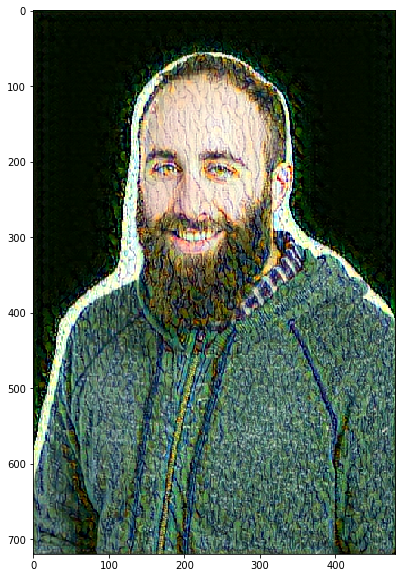

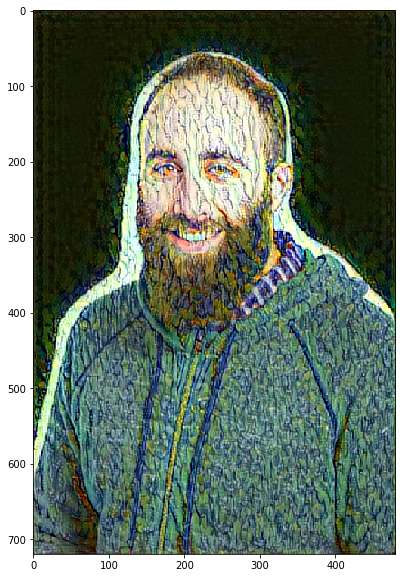

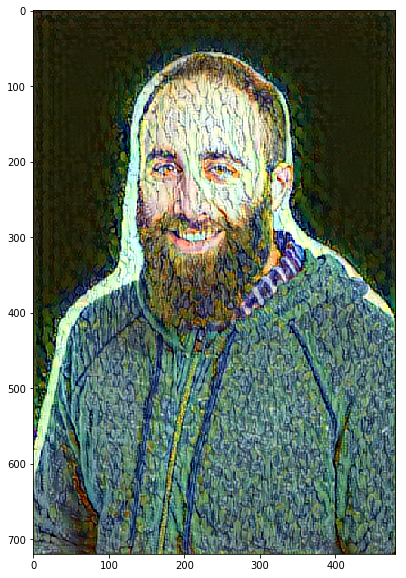

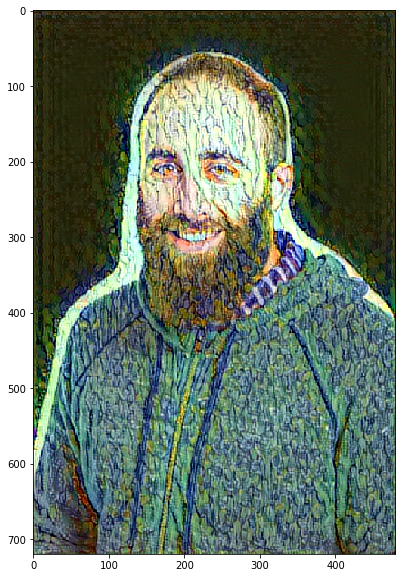

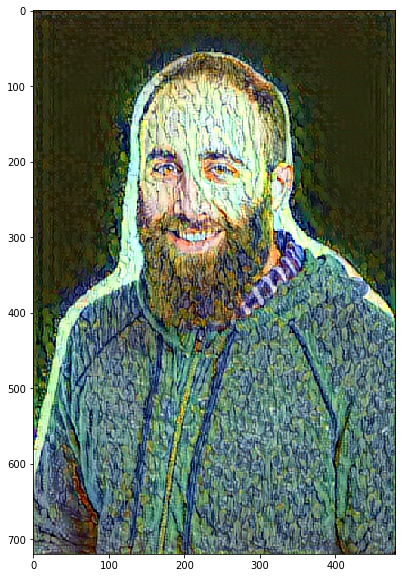

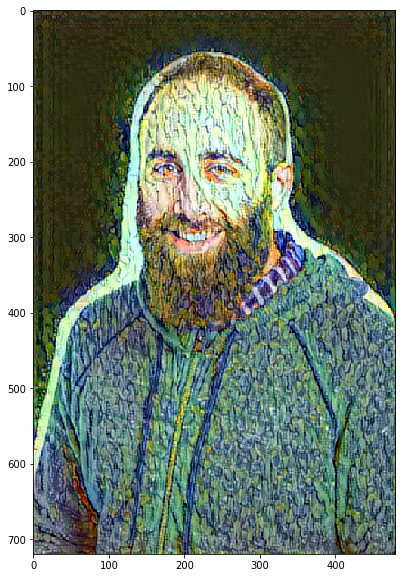

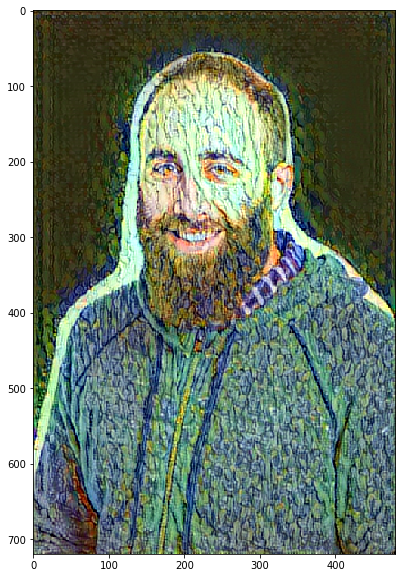

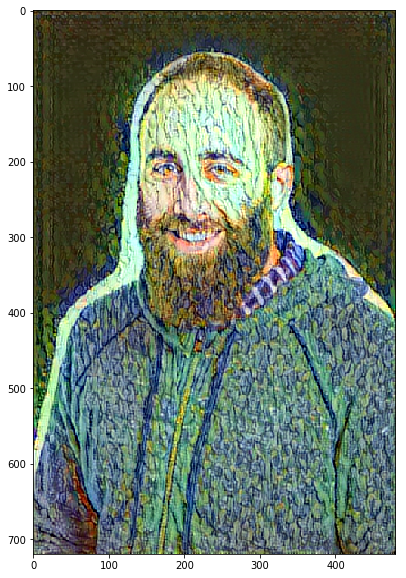

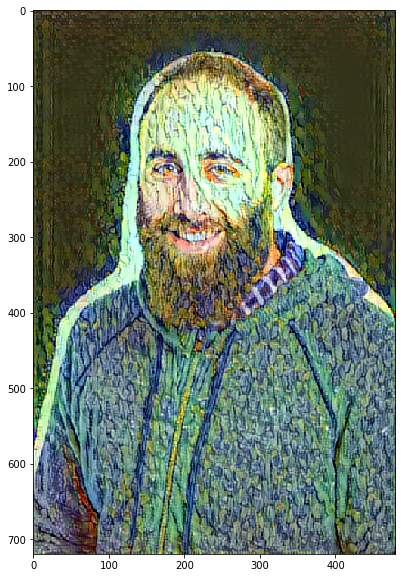

In [33]:
N_iterations = 10
for i in range(N_iterations-1):
    plt.figure(figsize = (10,10))
    style_back = get_style_back('/home/ec2-user/Notebooks/Style_transfer/output/transfered_image_at_iteration_{}.png'.format(i))
    plt.imshow(style_back.resize(image.size))
    plt.show()

In [ ]:
def main_choices():
    content_suffix, style_suffix, image = print_and_choose_content_style(content_path,style_path)